>>>Dados Prontos
>>>Treinando o modelo com Early Stopping... 
Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


42/42 ━━━━━━━━━━━━━━━━━━━━ 10s 131ms/step - loss: 0.0097 - val_loss: 9.8235e-04
Epoch 2/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 8s 74ms/step - loss: 0.0062 - val_loss: 1.3839e-04
Epoch 3/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 4s 108ms/step - loss: 0.0060 - val_loss: 6.1704e-04
Epoch 4/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 4s 88ms/step - loss: 0.0048 - val_loss: 9.7037e-05
Epoch 5/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 4s 61ms/step - loss: 0.0048 - val_loss: 2.1288e-04
Epoch 6/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 7s 101ms/step - loss: 0.0051 - val_loss: 1.2067e-04
Epoch 7/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 3s 81ms/step - loss: 0.0044 - val_loss: 1.5720e-04
Epoch 8/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 5s 68ms/step - loss: 0.0048 - val_loss: 1.3294e-04
Epoch 9/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 7s 115ms/step - loss: 0.0054 - val_loss: 1.6750e-04
Epoch 10/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 3s 65ms/step - loss: 0.0060 - val_loss: 1.3517e-04
Epoch 11/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step - loss: 0.0057 - val_loss: 2.3953e-04
Epoch 12/100
42

/tmp/ipython-input-3-1231573699.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions


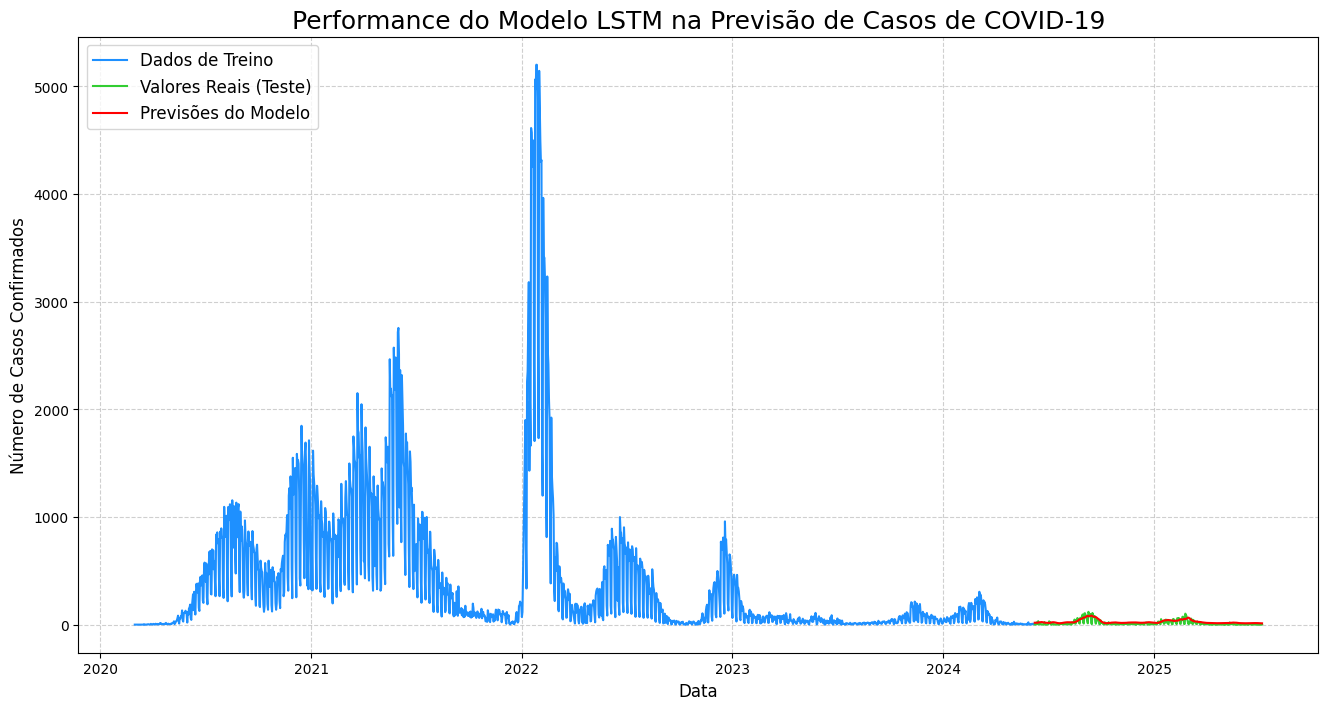

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.callbacks import EarlyStopping  #
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Carregar e Preparar os Dados (Completo)
try:
    df_cases = pd.read_excel('/content/drive/MyDrive/dados_covid/casos_confirmadoXobitos.xlsx', engine='openpyxl')
    df_vax = pd.read_excel('/content/drive/MyDrive/dados_covid/96ab09e2-0583-4e0a-bedf-d7533e8c5c2e.xlsx', engine='openpyxl')

    df_cases['DATA AJUSTADA'] = pd.to_datetime(df_cases['DATA AJUSTADA'])
    df_cases.set_index('DATA AJUSTADA', inplace=True)
    df_vax['Data da Vacina'] = pd.to_datetime(df_vax['Data da Vacina'])
    df_vax.set_index('Data da Vacina', inplace=True)
    df_combined = df_cases.join(df_vax, how='outer').fillna(0)
    df_combined.sort_index(inplace=True)
    data_casos = df_combined.filter(['Confirmados'])
    dataset_casos = data_casos.values
    tamanho_treino = int(np.ceil(len(dataset_casos) * 0.8))
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(dataset_casos)
    dados_treino = scaled_data[0:tamanho_treino, :]
    X_train, y_train = [], []
    timesteps = 60
    for i in range(timesteps, len(dados_treino)):
        X_train.append(dados_treino[i-timesteps:i, 0])
        y_train.append(dados_treino[i, 0])
    X_train, y_train = np.array(X_train), np.array(y_train)
    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
    dados_teste = scaled_data[tamanho_treino - timesteps:, :]
    X_test = []
    y_test = dataset_casos[tamanho_treino:, :]
    for i in range(timesteps, len(dados_teste)):
        X_test.append(dados_teste[i-timesteps:i, 0])
    X_test = np.array(X_test)
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

    print(">>>Dados Prontos")

    # Construir a Arquitetura do Modelo LSTM
    model = Sequential()
    model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
    model.add(Dropout(0.2))
    model.add(LSTM(units=50, return_sequences=False))
    model.add(Dropout(0.2))
    model.add(Dense(units=1))

    # Compilar o Modelo
    model.compile(optimizer='adam', loss='mean_squared_error')

    # CRIAR A REGRA DE EARLY STOPPING
    # Monitora a perda na validação ('val_loss')
    # 'patience=10' significa que ele espera 10 épocas por uma melhora antes de parar
    # 'restore_best_weights=True' garante que o modelo volte para os melhores pesos que encontrou
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

    # Treinar o Modelo COM EARLY STOPPING
    print(">>>Treinando o modelo com Early Stopping... ")

    history = model.fit(X_train, y_train, batch_size=32, epochs=100,
                        validation_split=0.1,
                        callbacks=[early_stopping])

    # Avaliação do Modelo
    print(">>>Previsões no conjunto de teste...")
    predictions = model.predict(X_test)
    predictions = scaler.inverse_transform(predictions)
    rmse = np.sqrt(np.mean(((predictions - y_test)**2)))
    print(f"\nErro do Modelo (RMSE): {rmse:.2f}")

    # Visualizar os Resultados
    print(">>>Gráfico de resultados... ")
    train = data_casos[:tamanho_treino]
    valid = data_casos[tamanho_treino:]
    valid['Predictions'] = predictions

    plt.figure(figsize=(16,8))
    plt.title('Performance do Modelo LSTM na Previsão de Casos de COVID-19', fontsize=18)
    plt.xlabel('Data', fontsize=12)
    plt.ylabel('Número de Casos Confirmados', fontsize=12)
    plt.plot(train['Confirmados'], color='dodgerblue', label='Dados de Treino')
    plt.plot(valid[['Confirmados']], color='limegreen', label='Valores Reais (Teste)')
    plt.plot(valid[['Predictions']], color='red', label='Previsões do Modelo')
    plt.legend(loc='upper left', fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.show()

except Exception as e:
    print(f"Ocorreu um erro inesperado: {e}")